**Brian Blaylock**  
**May 16, 2018**

# **Fig. 4.** Case Events: Scores

![](./figs/Fig-05-Cases-Scores.png)

> FIG. 5. a) Base rate and forecast rate denoting fractional area of Texas that observed and forecasted lightning in the previous hour for F01-F18 valid at 0200 UTC 16 May 2018 (left) with FAR and POD (center) and FSS with 30, 60, 120, and 240 km radial neighborhoods and FSSuniform in grey dashed line (right) for the same forecasts. b) as in a) except scores are for the Colorado area valid 2100 UTC 5 July 2018. c) as in a) except scores are fore the Utah area valid 0600 UTC 17 July 2018.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from matplotlib.path import Path

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap
from BB_HRRR.HRRR_Pando import get_hrrr_latlon, get_hrrr_variable
from BB_HRRR.GLM_and_HRRR.GLM_events_HRRR import get_GLM_HRRR_contingency_stats,\
                                                 hit_rate, \
                                                 false_alarm_ratio,\
                                                 base_rate, \
                                                 forecast_rate
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM_FAST

from fires_list import get_fire

Create HRRR map.
loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_c_2000.npy map from file
Forecasts [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Generate domains and masks.
HRRR Area in meters squared: 16811840278558.668
West Area in meters squared: 4034896806752.7593
Central Area in meters squared: 4034896806752.766
East Area in meters squared: 4034896806752.762
Utah Area in meters squared: 219973261639.39685
Colorado Area in meters squared: 269906899003.7569
Texas Area in meters squared: 688270731111.2987
Florida Area in meters squared: 149996892486.02234
dict_keys(['HRRR', 'West', 'Central', 'East', 'Utah', 'Colorado', 'Texas', 'Florida'])


In [19]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [7.4, 7.2]
mpl.rcParams['figure.titlesize'] = 10
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.25
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['grid.alpha'] = .5
mpl.rcParams['figure.subplot.wspace'] = 0.2
mpl.rcParams['figure.subplot.hspace'] = 0.5

mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .95
mpl.rcParams['legend.labelspacing'] = 0.3
mpl.rcParams['legend.handlelength'] = 1
mpl.rcParams['legend.handletextpad'] = 0.5
mpl.rcParams['legend.borderaxespad'] = 0.3
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.columnspacing'] = 1.0


mpl.rcParams['savefig.bbox'] = 'tight'  
mpl.rcParams['savefig.dpi'] = 600

# Single Datetime: Hit Rate/ False Alarm Ratio

In [3]:
def get_GLM_HRRR_stats_day(DATE, DOMAIN, verbose=True):
    DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
    FILE = '/%s/%s_%s_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, DATE.year, DATE.month, DATE.hour)

    data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')
    # NOTE: Set encoding to 'UTF-8' so the date doesn't return as bytes

    if verbose:
        print(data.dtype.names)
    
    # Get the data from the line that cooresponds to the date requested
    line = data[DATE.day-1]

    # Double check that the line we got is the date requested
    if datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S') != DATE:
        print('WARNING: Date of this line does not match the requested DATE')
        print('Grabbed date ', line[0])
    
    if verbose:
        #number of flashes
        num_flashes = int(line[1])
        print('Got {:,} events in {:} domain ({:} of {:} files).'.format(num_flashes, DOMAIN, line[2], line[3]))
    
    return line

def get_GLM_HRRR_FSS_day(DATE, DOMAIN, radius, verbose=True):
    DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_Fractions_Skill_Score_r%02d/' % radius
    FILE = '%s/%s_%s_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, DATE.year, DATE.month, DATE.hour)

    data = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')
    # NOTE: Set encoding to 'UTF-8' so the date doesn't return as bytes

    if verbose:
        print(data.dtype.names)
    
    # Get the data from the line that cooresponds to the date requested
    line = data[DATE.day-1]

    # Double check that the line we got is the date requested
    try:
        check_date = datetime.strptime(line[0], '%Y-%m-%d %H:%M:%S')
    except:
        check_date = datetime.strptime(line[0], '%m/%d/%Y %H:%M')
    if check_date != DATE:
        print('WARNING: Date of this line does not match the requested DATE')
        print('Grabbed date ', line[0])
    
    if verbose:
        #number of flashes
        num_flashes = int(line[1])
        print('Got {:,} events in {:} domain ({:} of {:} files).'.format(num_flashes, DOMAIN, line[2], line[3]))
    
    return line


In [28]:
def plot_s_r(ax):
    '''Base Rate (s) and Forecast Rate (r)'''
    ax.plot(range(1,19), baseRate, label='Base Rate', color='r')
    ax.plot(range(1,19), fxxRate, label='Forecast Rate')
    ax.set_xlabel('Lead Time (hours)')
    ax.set_ylim(0, 0.23)
    ax.set_yticks(np.arange(0,.23, .05))
    ax.set_xticks([1,3,6,9,12,15,18])
    ax.set_xticklabels(['F%02d' % f for f in [1,3,6,9,12,15,18]])
    ax.legend(loc=1)
    ax.grid()
    ax.invert_xaxis()
    #ax.set_title(label, fontsize=14, position=(-0.1,1))

In [29]:
def plot_POD_FAR(ax):
    '''Hit Rate and False Alarm Ratio'''
    ax.plot(range(1,19), FAR, label='FAR')
    ax.plot(range(1,19), POD, label='POD')
    ax.set_xlabel('Lead Time (hours)')
    ax.set_ylim(0, 1)
    ax.set_xticks([1,3,6,9,12,15,18])
    ax.set_xticklabels(['F%02d' % f for f in [1,3,6,9,12,15,18]])
    ax.grid()
    ax.legend(loc=1)
    ax.invert_xaxis()
    #ax.set_title('%s scores valid %s' % (domain, DATE.strftime('%H:%M UTC %d %b %Y')),
    #             fontweight='bold')

In [30]:
def plot_FSS(ax):
    '''Fraction Skill Score'''
    for fss, r in zip(FSS, radii):
        values = [fss['F%02d_FSS' % h] for h in range(1,19)]
        ax.plot(range(1,19), values, label=r'FSS$\mathregular{_{%s}}$' % (r*3))
    ax.plot(range(1,19), FSS_uniform, linestyle='--', color='grey', zorder=0)
    ax.set_xlabel('Lead Time (hours)')
    ax.set_ylim(0, 1)
    ax.set_xticks([1,3,6,9,12,15,18])
    ax.set_xticklabels(['F%02d' % f for f in [1,3,6,9,12,15,18]])
    ax.grid()
    if domain == 'Utah':
        ax.legend(loc=1, ncol=2)
    else:
        ax.legend(loc=4, ncol=2)
    ax.invert_xaxis()

# Scores for three cases

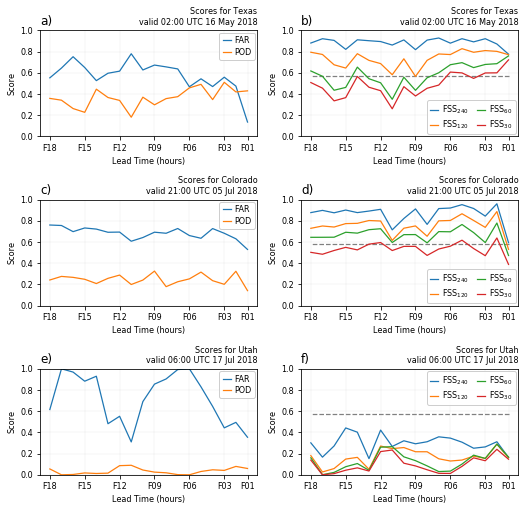

In [31]:
events = ['Mallard', 'Lake Christine', 'July Storm']
domains = ['Texas', 'Colorado', 'Utah']
labels = [['a)', 'b)'],['c)', 'd)'],['e)', 'f)']]
fig, axes = plt.subplots(3,2)
for ax, event, domain, label in zip(axes, events, domains, labels):
    FIRE = get_fire(event)
    DATE = FIRE['event']
    NAME = FIRE['name']
    
    # Load data
    line = get_GLM_HRRR_stats_day(DATE, domain, verbose=False)
    A = np.array([line['F%02d_A' % (i)] for i in range(1,19)])
    B = np.array([line['F%02d_B' % (i)] for i in range(1,19)])
    C = np.array([line['F%02d_C' % (i)] for i in range(1,19)])
    D = np.array([line['F%02d_D' % (i)] for i in range(1,19)])
    
    POD = hit_rate(A, B, C, D)
    FAR = false_alarm_ratio(A, B, C, D)
    baseRate = base_rate(A, B, C, D)
    fxxRate = forecast_rate(A, B, C, D)
    
    radii = [80, 40, 20, 10]  # Grid point radii
    FSS_uniform = 0.5 + baseRate/2
    FSS = [get_GLM_HRRR_FSS_day(DATE, domain, r, verbose=False) for r in radii]
    
    # Base Rate and Forecast Rate
    #plot_s_r(ax[0])
    
    # Probability of Detection (POD) and False alarm ratio (FAR)
    plot_POD_FAR(ax[0])
    
    # FSS
    plot_FSS(ax[1])
    
    ax[0].set_title(label[0], loc='left', fontsize=12)
    ax[1].set_title(label[1], loc='left', fontsize=12)
    
   
    for aa in ax:
        aa.set_title('Scores for %s\nvalid %s' % (domain, DATE.strftime('%H:%M UTC %d %b %Y')), loc='right', fontsize=8)
        aa.set_ylabel('Score')
    

fig.tight_layout()

plt.savefig('./figs/Fig-05-Cases-Scores')

# _Not Shown_: Scores for May 2019 Thunderstorm

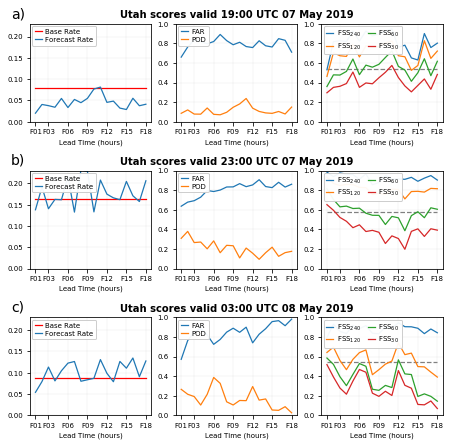

In [13]:
events = ['May Storm', 'May Storm', 'May Storm']
domain = ['Utah', 'Utah', 'Utah']
#domain = ['West', 'West', 'West']
DATES = [datetime(2019, 5, 7, 19), datetime(2019, 5, 7, 23), datetime(2019, 5, 8, 3)]
fig, axes = plt.subplots(3,3)
for ax, event, domain, DATE, label in zip(axes, events, domain, DATES, ['a)', 'b)', 'c)']):
    NAME = ['May 2019 Storm']
    
    # Load data
    line = get_GLM_HRRR_stats_day(DATE, domain, verbose=False)
    A = np.array([line['F%02d_A' % (i)] for i in range(1,19)])
    B = np.array([line['F%02d_B' % (i)] for i in range(1,19)])
    C = np.array([line['F%02d_C' % (i)] for i in range(1,19)])
    D = np.array([line['F%02d_D' % (i)] for i in range(1,19)])
    
    POD = hit_rate(A, B, C, D)
    FAR = false_alarm_ratio(A, B, C, D)
    baseRate = base_rate(A, B, C, D)
    fxxRate = forecast_rate(A, B, C, D)
    
    radii = [80, 40, 20, 10]  # Grid point radii
    FSS_uniform = 0.5 + baseRate/2
    FSS = [get_GLM_HRRR_FSS_day(DATE, domain, r, verbose=False) for r in radii]
    
    # Base Rate and Forecast Rate
    plot_s_r(ax[0])
    
    # Probability of Detection (POD) and False alarm ratio (FAR)
    plot_POD_FAR(ax[1])
    
    # FSS
    plot_FSS(ax[2])
    
plt.savefig('./figs/not-shown_Cases-Scores_May2019')

#### Make individual plots

/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:127: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:154: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


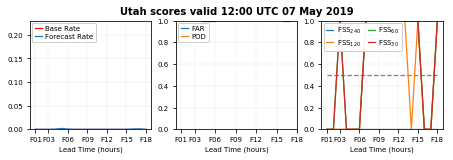

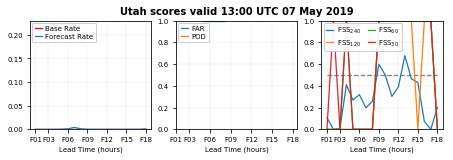

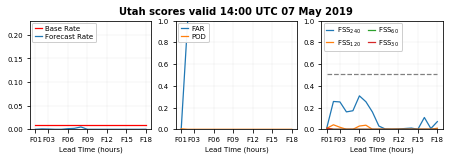

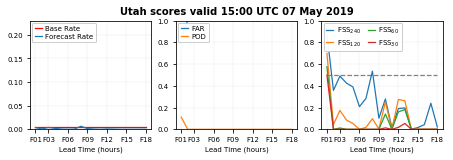

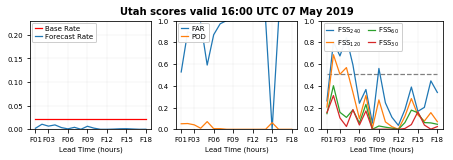

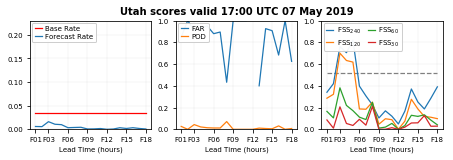

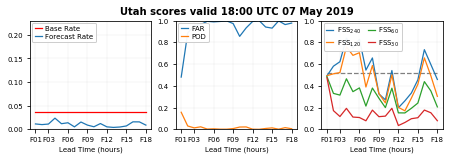

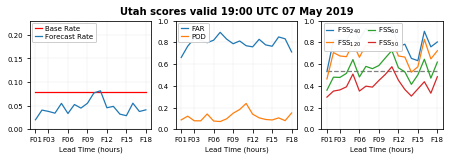

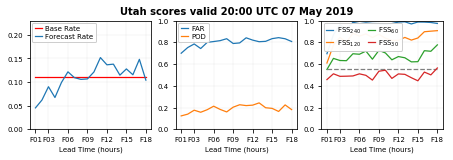

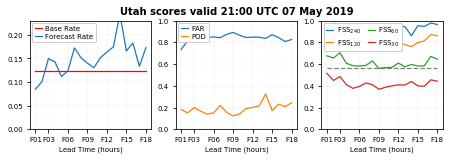

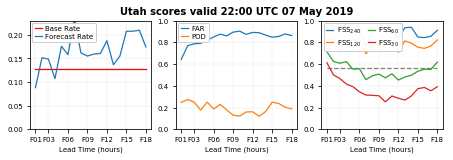

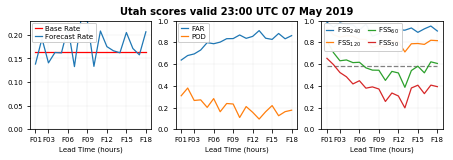

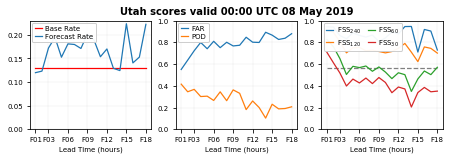

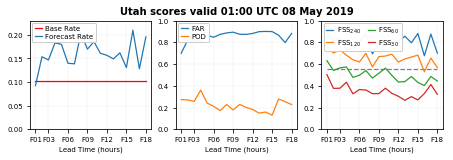

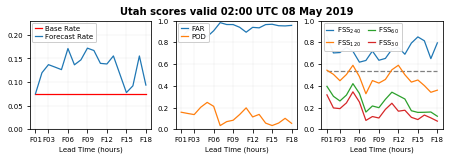

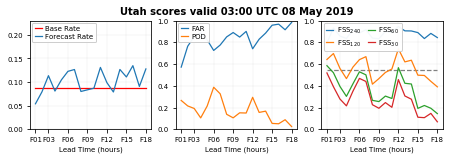

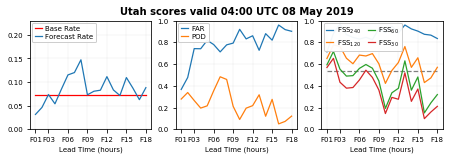

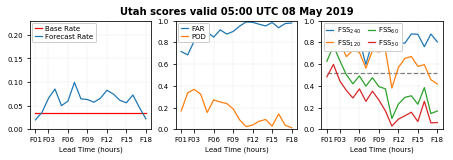

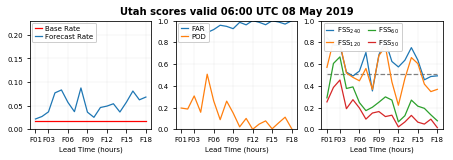

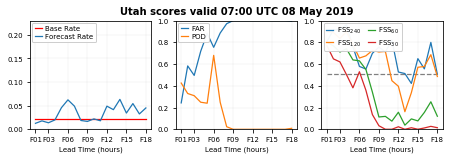

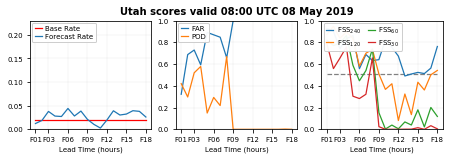

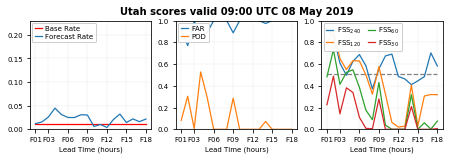

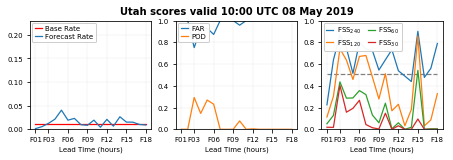

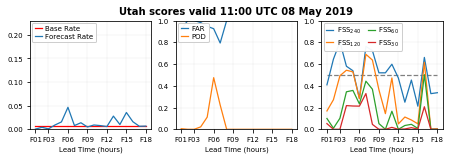

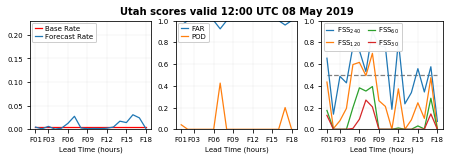

In [26]:
sDATE = datetime(2019, 5, 7, 12)
eDATE = datetime(2019, 5, 8, 13)
hours = int((eDATE-sDATE).days*24 + (eDATE-sDATE).seconds/60/60)
DATES = [sDATE+timedelta(hours=h) for h in range(hours)]


for DATE in DATES:
    fig, axes = plt.subplots(1,3, figsize=[7.4, 2.])
    event = 'May Storm'
    domain = 'Utah'
    NAME = ['May 2019 Storm']
    label = ''
    ax = axes
    # Load data
    line = get_GLM_HRRR_stats_day(DATE, domain, verbose=False)
    A = np.array([line['F%02d_A' % (i)] for i in range(1,19)])
    B = np.array([line['F%02d_B' % (i)] for i in range(1,19)])
    C = np.array([line['F%02d_C' % (i)] for i in range(1,19)])
    D = np.array([line['F%02d_D' % (i)] for i in range(1,19)])
    
    POD = hit_rate(A, B, C, D)
    FAR = false_alarm_ratio(A, B, C, D)
    baseRate = base_rate(A, B, C, D)
    fxxRate = forecast_rate(A, B, C, D)
    
    radii = [80, 40, 20, 10]  # Grid point radii
    FSS_uniform = 0.5 + baseRate/2
    FSS = [get_GLM_HRRR_FSS_day(DATE, domain, r, verbose=False) for r in radii]
    
    # Base Rate and Forecast Rate
    plot_s_r(ax[0])
    
    # Probability of Detection (POD) and False alarm ratio (FAR)
    plot_POD_FAR(ax[1])
    
    # FSS
    plot_FSS(ax[2])
    
    plt.savefig('./figs/May2019/cases-Scores_%s' % DATE.strftime('%Y%m%d_%H%M'))

## _Not Shown_: Generate figs for -6 hours through +6 hours of the event time for the three 2018 cases

In [9]:
events = ['Mallard', 'Lake Christine', 'July Storm']
domains = ['Texas', 'Colorado', 'Utah']



houroffset = [-6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6]

for offset in houroffset:

    fig, axes = plt.subplots(3,3)
    for ax, event, domain, label in zip(axes, events, domains, ['a)', 'b)', 'c)']):
        FIRE = get_fire(event)
        DATE = FIRE['event'] + timedelta(hours=offset)
        NAME = FIRE['name']

        # Load data
        line = get_GLM_HRRR_stats_day(DATE, domain, verbose=False)
        A = np.array([line['F%02d_A' % (i)] for i in range(1,19)])
        B = np.array([line['F%02d_B' % (i)] for i in range(1,19)])
        C = np.array([line['F%02d_C' % (i)] for i in range(1,19)])
        D = np.array([line['F%02d_D' % (i)] for i in range(1,19)])

        POD = hit_rate(A, B, C, D)
        FAR = false_alarm_ratio(A, B, C, D)
        baseRate = base_rate(A, B, C, D)
        fxxRate = forecast_rate(A, B, C, D)

        radii = [80, 40, 20, 10]  # Grid point radii
        FSS_uniform = 0.5 + baseRate/2
        FSS = [get_GLM_HRRR_FSS_day(DATE, domain, r, verbose=False) for r in radii]

        # Base Rate and Forecast Rate
        plot_s_r(ax[0])

        # Probability of Detection (POD) and False alarm ratio (FAR)
        plot_POD_FAR(ax[1])

        # FSS
        plot_FSS(ax[2])

    plt.savefig('./figs/Fig-05-Cases-Scores_HOUR%s' % offset)
    plt.close()

/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:127: RuntimeWarning: invalid value encountered in true_divide
  H = a/(a+c)
/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_wx_calcs/binary_events.py:154: RuntimeWarning: invalid value encountered in true_divide
  FAR = b/(a+b)
